## Part 1. Data gathering

In [1]:
# Importing the necessary libraries to use YouTube API
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON

# Importing data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Defining a variable to store API key
api_key = 'xxx' # Insert your API key here

In [3]:
# Defining the channel to search for videos
channel_ids = ['UCZ4AMrDcNrfy3X6nsU8-rPg',]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Getting credentials and create an API client
youtube = build(
        api_service_name, api_version, developerKey=api_key)

def get_channel_stats(youtube, channel_ids):

        data_res = []

        request = youtube.channels().list(
        part='snippet, contentDetails, statistics',
        id= ','.join(channel_ids)
        )
        response = request.execute()

        # loop through items
        for item in response['items']:
                data = {'channelName': item['snippet']['title'],
                        'subscribers': item['statistics']['subscriberCount'],
                        'views': item['statistics']['viewCount'],
                        'totalViews': item['statistics']['videoCount'],
                        'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
                        }
                data_res.append(data)
                
        return(pd.DataFrame(data_res))


In [5]:
# Using the function and displaying the dataset
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats

,channelName,subscribers,views,totalViews,playlistId
0,Economics Explained,2520000,293675464,347,UUZ4AMrDcNrfy3X6nsU8-rPg


In [6]:
def get_video_ids(youtube, playlist_id):
    
    # Initializing an empty list to store video IDs
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()

    # Looping through pages of playlist items
    while 'nextPageToken' in response:
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response['nextPageToken']
        request = youtube.playlistItems().list(
            part="snippet, contentDetails",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()

    # Fetching the remaining videos (if any) with the last request
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])

    return video_ids



In [7]:
playlist_id = 'UUZ4AMrDcNrfy3X6nsU8-rPg'

In [8]:
# Testing the function and finding the length to verify it has captured all videos in the channel
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

347

In [9]:
def get_video_details(youtube, video_ids):

    # Initializing an empty list to store video details
    video_data = []

    # Iterating over video IDs in batches of 50 (YouTube API limit)
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet, contentDetails, statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        # Looping through items in the response
        for video in response['items']:
            stats = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                    'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                    'contentDetails': ['duration', 'definition', 'caption']
                    }
            video_info = {}
            video_info['video_id'] = video['id']

            # Extracting statistics and snippet information for each video
            for k in stats.keys():
                for v in stats[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None
        
            video_data.append(video_info)
    
    return pd.DataFrame(video_data)

In [10]:
# Using the function to create a dataframe with video info
video_df = get_video_details(youtube, video_ids)
video_df.head(3)

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07T13:00:19Z,287759,9235,None,1099,PT13M25S,hd,true
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31T13:10:09Z,462379,15264,None,1745,PT13M30S,hd,true
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24T14:00:43Z,357970,13236,None,1324,PT15M17S,hd,true


## Part 2. Data preprocessing

Insert code here to create a copy of the video_df for further processing and to avoid make new API requests

In [11]:
# Creating a copy to work with the dataset
video_cleaned = video_df.copy()

In [12]:
# Finding null values in the dataframe
video_cleaned.isna().sum()

video_id            0
channelTitle        0
title               0
description         0
tags                3
publishedAt         0
viewCount           0
likeCount           0
favouriteCount    347
commentCount        0
duration            0
definition          0
caption             0
dtype: int64

In [13]:
# Finding data types in the dataframe
video_cleaned.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [14]:
# Converting columns with numerical values into numbers
num_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_cleaned[num_cols] = video_df[num_cols].apply(pd.to_numeric, errors='coerce', axis=1)
video_cleaned.dtypes

video_id           object
channelTitle       object
title              object
description        object
tags               object
publishedAt        object
viewCount         float64
likeCount         float64
favouriteCount    float64
commentCount      float64
duration           object
definition         object
caption            object
dtype: object

In [15]:
# Eliminating the favoriteCount, caption and definition columns and changing columns' names
video_cleaned = video_cleaned.drop(['favouriteCount', 'caption', 'definition'], axis=1)

video_cleaned.columns = ['video_id', 'channel', 'title', 'description', 'tags', 'published_at', 'views', 'likes', 'comments', 'duration']

video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07T13:00:19Z,287759.0,9235.0,1099.0,PT13M25S
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31T13:10:09Z,462379.0,15264.0,1745.0,PT13M30S
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24T14:00:43Z,357970.0,13236.0,1324.0,PT15M17S


In [16]:
# Adding columns to extract day parts
# Converting 'published_at' column to pandas datetime object
video_cleaned['published_at'] = pd.to_datetime(video_cleaned['published_at'])

# Extract year, month name, day (numeric and name), and hour of the day
video_cleaned['year'] = video_cleaned['published_at'].dt.year
video_cleaned['month_name'] = video_cleaned['published_at'].dt.month_name()
video_cleaned['day_num'] = video_cleaned['published_at'].dt.day
video_cleaned['weekday'] = video_cleaned['published_at'].dt.day_name()
video_cleaned['hour'] = video_cleaned['published_at'].dt.hour

video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,year,month_name,day_num,weekday,hour
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,2024,April,7,Sunday,13
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,2024,March,31,Sunday,13
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,2024,March,24,Sunday,14


In [17]:
# Creating a function to make the duration more readable
import re
from datetime import timedelta

def parse_duration(duration):
    match = re.match(r'PT((\d+)H)?((\d+)M)?((\d+)S)?', duration)
    if match:
        hours = int(match.group(2)) if match.group(2) else 0
        minutes = int(match.group(4)) if match.group(4) else 0
        seconds = int(match.group(6)) if match.group(6) else 0
        return timedelta(hours=hours, minutes=minutes, seconds=seconds)
    else:
        return None


In [18]:
# Applying the function to the duration column
video_cleaned['dur_readable'] = video_cleaned['duration'].apply(lambda x: parse_duration(x))
video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,year,month_name,day_num,weekday,hour,dur_readable
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,2024,April,7,Sunday,13,0 days 00:13:25
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,2024,March,31,Sunday,13,0 days 00:13:30
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,2024,March,24,Sunday,14,0 days 00:15:17


### Tag section

In [19]:
# Adding a column for the tag count
video_cleaned['tag_count'] = video_cleaned['tags'].apply(lambda x: 0 if x is None else len(x))


In [20]:
video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,year,month_name,day_num,weekday,hour,dur_readable,tag_count
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,2024,April,7,Sunday,13,0 days 00:13:25,11
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,2024,March,31,Sunday,13,0 days 00:13:30,12
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,2024,March,24,Sunday,14,0 days 00:15:17,11


In [21]:
video_cleaned['tags_list'] = video_cleaned['tags'].apply(lambda x: [tag.strip() for tag in x] if isinstance(x, list) else [])

video_cleaned.head(3)

tags_count = {}  # Dictionary to store tag counts

# Iterate over each row in the DataFrame
for tags_list in video_cleaned['tags_list']:
    # Iterate over the tags list in each row
    for tag in tags_list:
        # If the tag is already in the dictionary, increment its count
        if tag in tags_count:
            tags_count[tag] += 1
        # If the tag is not in the dictionary, add it with a count of 1
        else:
            tags_count[tag] = 1

# Create an empty list to store tag counts as tuples
tag_count_tuples = []

# Iterate over the tags and counts and append them to the list as tuples
for tag, count in tags_count.items():
    tag_count_tuples.append((tag, count))

# Sort the list of tuples based on the count in descending order
tag_count_tuples.sort(key=lambda x: x[1], reverse=True)

# Print the top 30 tags with the highest count
for i, (tag, count) in enumerate(tag_count_tuples[:20], start=1):
    print(f"{i}. {tag}: {count}")

1. economics explained: 339
2. economics: 237
3. economy explained: 63
4. china economy: 11
5. china: 11
6. explained: 11
7. economy: 10
8. hyperinflation: 10
9. inflation: 10
10. economic collapse: 7
11. income inequality: 7
12. recession: 7
13. world reserve currency: 7
14. chinese economy: 6
15. economic inequality: 6
16. stock market crash: 6
17. supply and demand: 6
18. economy of china: 6
19. china housing bubble: 6
20. economics explained china: 6


In [22]:
from collections import Counter

# Create a Counter object to store tag counts
tag_counter = Counter()

# Iterate over each row
for tags_list in video_cleaned['tags_list']:
    # Update the tag counter with the tags in the current row
    tag_counter.update(tags_list)

# Convert Counter object to a DataFrame
tag_df = pd.DataFrame(tag_counter.items(), columns=['tag', 'count'])

# Sort the DataFrame by count in descending order
tag_df = tag_df.sort_values(by='count', ascending=False)

# Display the DataFrame
tag_df.head(10)
# tag_df.to_csv('tag_counts.csv', index=False)


,tag,count
1,economics explained,339
0,economics,237
2,economy explained,63
408,china,11
430,explained,11
10,china economy,11
524,inflation,10
449,hyperinflation,10
375,economy,10
522,recession,7


In [23]:
tag_df.shape

(3140, 2)

#### POS

In [24]:
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sample text data
text_data = "China has a large economy with many economic challenges, including poverty and farming issues."

# Tokenize the text
tokens = word_tokenize(text_data)

# Perform POS tagging
pos_tags = nltk.pos_tag(tokens)

# Initialize a dictionary to store words by their POS tags
pos_words = {}

# Iterate over each token and its POS tag
for token, pos_tag in pos_tags:
    # Add the token to the corresponding POS tag category in the dictionary
    if pos_tag in pos_words:
        pos_words[pos_tag].append(token)
    else:
        pos_words[pos_tag] = [token]

# Print each POS tag along with the words belonging to that category
for pos_tag, words in pos_words.items():
    print(f"{pos_tag}: {len(words)}")
    print(words)
    print()

NNP: 1
['China']

VBZ: 1
['has']

DT: 1
['a']

JJ: 3
['large', 'many', 'economic']

NN: 2
['economy', 'poverty']

IN: 1
['with']

NNS: 2
['challenges', 'issues']

,: 1
[',']

VBG: 2
['including', 'farming']

CC: 1
['and']

.: 1
['.']



In [25]:
# Set the maximum width for displaying columns
pd.set_option('display.max_colwidth', None)

print(video_cleaned['title'])

0                                       Why Bangladesh Won't Be The Next China
1                                              Is the European Union Worth It?
2                                                   Why We Can’t Just Stop Oil
3      Is German Precision Manufacturing Over? #economicsexplained #germanmade
4                                      USA Outgrows China… Because of Florida?
                                        ...                                   
342          How This Man Profited $1 Billion Betting on Hong Kong Horse Races
343                                                   The Economics of Poverty
344       The Economics of Automation: What Does Our Machine Future Look Like?
345                           Australians are the Richest People in the World?
346                                         Norway: Is It The Perfect Economy?
Name: title, Length: 347, dtype: object


In [26]:
pipe_pattern = re.compile(r'[\|#]')

# Filter rows with titles containing "|"
titles_with_pipe = video_cleaned[video_cleaned['title'].str.contains(pipe_pattern)]

# Print the filtered rows
titles_with_pipe.shape


(121, 18)

In [27]:
pd.reset_option('display.max_colwidth')

In [28]:
# Create a new column 'processed_title' and copy the values from 'title'
video_cleaned['processed_title'] = video_cleaned['title']
video_cleaned.head(3)


,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,year,month_name,day_num,weekday,hour,dur_readable,tag_count,tags_list,processed_title
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,2024,April,7,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Won't Be The Next China
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,2024,March,31,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It?
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,2024,March,24,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Can’t Just Stop Oil


In [29]:
# Removing pipes and hashtags characters and all the text after them
video_cleaned['processed_title'] = video_cleaned['processed_title'].apply(lambda x: re.sub(r'\||#.*', '', x))

# Replacing incorrect apostrophes and verifying changes
video_cleaned['processed_title'] = video_cleaned['processed_title'].str.replace("â€™", "'")
print(video_cleaned['processed_title'].iloc[25])

# Deleting the "Economics Explained" string
video_cleaned['processed_title'] = video_cleaned['processed_title'].str.replace("Economics Explained", "")
print(video_cleaned['processed_title'].iloc[7])

# Removing possessives
video_cleaned['processed_title'] = video_cleaned['processed_title'].apply(lambda x: re.sub(r"\b’?s\b|'\b|´\b", "", x))
print(video_cleaned['processed_title'].iloc[11])


# Remove special characters from the titles
video_cleaned['processed_title'] = video_cleaned['processed_title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))



How Bad Economics Killed Millions
Why Canada Can't Solve Its Population Problem with Immigration
The Rather Pathetic Economy of the Roman Empire


In [30]:
video_cleaned['processed_title']

0                  Why Bangladesh Wont Be The Next China
1                         Is the European Union Worth It
2                              Why We Cant Just Stop Oil
3                Is German Precision Manufacturing Over 
4                  USA Outgrows China Because of Florida
                             ...                        
342    How This Man Profited 1 Billion Betting on Hon...
343                             The Economics of Poverty
344    The Economics of Automation What Does Our Mach...
345      Australians are the Richest People in the World
346                     Norway Is It The Perfect Economy
Name: processed_title, Length: 347, dtype: object

In [31]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Define a function to perform POS tagging
def tag_tokens(sentence):
    return pos_tag(word_tokenize(sentence))

# Perform POS tagging on the processed_title column
video_cleaned['pos_tags'] = video_cleaned['processed_title'].apply(tag_tokens)
video_cleaned.head(3)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sydney\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Sydney\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,year,month_name,day_num,weekday,hour,dur_readable,tag_count,tags_list,processed_title,pos_tags
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,2024,April,7,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Wont Be The Next China,"[(Why, WRB), (Bangladesh, NNP), (Wont, NNP), (..."
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,2024,March,31,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It,"[(Is, VBZ), (the, DT), (European, NNP), (Union..."
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,2024,March,24,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Cant Just Stop Oil,"[(Why, WRB), (We, PRP), (Cant, NNP), (Just, NN..."


In [32]:
# Flatten the list of keywords
all_keywords = [keyword for keywords_list in video_cleaned['pos_tags'] for keyword in keywords_list]

# Initialize a count dictionary
word_counts = {}

# Count the occurrences of each word
for keyword in all_keywords:
    if keyword in word_counts:
        word_counts[keyword] += 1
    else:
        word_counts[keyword] = 1

# Create a DataFrame from the word counts
word_counts_df = pd.DataFrame(list(word_counts.items()), columns=['word_pos', 'count'])

# Split the 'Word_POS' column into separate 'Word' and 'POS' columns
word_counts_df[['word', 'pos']] = pd.DataFrame(word_counts_df['word_pos'].tolist())


# Sort the DataFrame by count in descending order
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Display the top words, their POS tags, and their counts
word_counts_df.head(10)



,word_pos,count,word,pos
4,"(The, DT)",190,The,DT
26,"(of, IN)",113,of,IN
48,"(Economy, NNP)",77,Economy,NNP
8,"(the, DT)",62,the,DT
0,"(Why, WRB)",53,Why,WRB
7,"(Is, VBZ)",39,Is,VBZ
121,"(How, WRB)",26,How,WRB
59,"(in, IN)",25,in,IN
6,"(China, NNP)",23,China,NNP
30,"(Economic, NNP)",23,Economic,NNP


In [33]:
# Mapping POS tags to their meanings
pos_definitions = {
    'NNP': 'Proper noun, singular',
    'NN': 'Noun, singular or mass',
    'JJ': 'Adjective',
    'NNS': 'Noun, plural',
    'VBG': 'Verb, gerund or present participle',
    'IN': 'Preposition or subordinating conjunction',
    'VB': 'Verb, base form',
    'CD': 'Cardinal number',
    'RB': 'Adverb',
    'NNPS': 'Proper noun, plural',
    'VBD': 'Verb, past tense',
    'DT': 'Determiner',
    'VBZ': 'Verb, 3rd person singular present',
    'VBP': 'Verb, non-3rd person singular present',
    'VBN': 'Verb, past participle',
    'PRP': 'Personal pronoun',
    'MD': 'Modal',
    'CC': 'Coordinating conjunction',
    'PRP$': 'Possessive pronoun',
    'JJR': 'Adjective, comparative',
    'JJS': 'Adjective, superlative',
    'WRB': 'Wh-adverb',
    'RP': 'Particle',
    'RBS': 'Adverb, superlative',
    'TO': 'to',
    'WP': 'Wh-pronoun',
    'PDT': 'Predeterminer',
    'FW': 'Foreign word',
    'WDT': 'Wh-determiner',
    'EX': 'Existential there'
}

# Add a column with POS definitions
word_counts_df['pos_def'] = word_counts_df['pos'].map(pos_definitions)

# Sort the DataFrame by count in descending order
word_counts_df = word_counts_df.sort_values(by='count', ascending=False)

# Display the top words, their POS tags, their counts, and POS definitions
word_counts_df.head(30)

,word_pos,count,word,pos,pos_def
4,"(The, DT)",190,The,DT,Determiner
26,"(of, IN)",113,of,IN,Preposition or subordinating conjunction
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular"
8,"(the, DT)",62,the,DT,Determiner
0,"(Why, WRB)",53,Why,WRB,Wh-adverb
7,"(Is, VBZ)",39,Is,VBZ,"Verb, 3rd person singular present"
121,"(How, WRB)",26,How,WRB,Wh-adverb
59,"(in, IN)",25,in,IN,Preposition or subordinating conjunction
6,"(China, NNP)",23,China,NNP,"Proper noun, singular"
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular"


In [34]:
generalized_pos = {
    'noun': ['NNP', 'NN', 'NNS', 'NNPS'],
    'adjective': ['JJ', 'JJR', 'JJS'],
    'verb': ['VBG', 'VB', 'VBD', 'VBZ', 'VBP', 'VBN'],
    'preposition': ['IN'],
    'number': ['CD'],
    'adverb': ['RB', 'WRB', 'RP', 'RBS'],
    'determiner': ['DT', 'PDT', 'WDT'],
    'pronoun': ['PRP', 'PRP$', 'WP'],
    'modal': ['MD'],
    'conjunction': ['CC'],
    'to': ['TO'],
    'foreign': ['FW'],
    'existential': ['EX']
}

# Invert the dictionary to have the broader categories as keys
inverted_generalized_pos = {v: k for k, values in generalized_pos.items() for v in values}

# Apply the mapping to create a new column with generalized POS categories
word_counts_df['gen_pos'] = word_counts_df['pos'].map(inverted_generalized_pos)

# Display the top words, their POS tags, and their counts with generalized categories
word_counts_df.head()

,word_pos,count,word,pos,pos_def,gen_pos
4,"(The, DT)",190,The,DT,Determiner,determiner
26,"(of, IN)",113,of,IN,Preposition or subordinating conjunction,preposition
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun
8,"(the, DT)",62,the,DT,Determiner,determiner
0,"(Why, WRB)",53,Why,WRB,Wh-adverb,adverb


In [35]:
word_counts_df['pos_def'].value_counts()

pos_def
Proper noun, singular                       601
Noun, singular or mass                       74
Adjective                                    49
Noun, plural                                 42
Verb, gerund or present participle           37
Preposition or subordinating conjunction     35
Verb, base form                              30
Cardinal number                              25
Adverb                                       16
Proper noun, plural                          14
Verb, past tense                             14
Determiner                                   13
Verb, 3rd person singular present            13
Verb, non-3rd person singular present        13
Verb, past participle                        10
Personal pronoun                              8
Modal                                         7
Coordinating conjunction                      5
Adjective, superlative                        4
Possessive pronoun                            4
Adjective, comparative          

In [36]:
word_counts_df['gen_pos'].value_counts()

gen_pos
noun           731
verb           117
adjective       57
preposition     35
number          25
adverb          23
determiner      15
pronoun         14
modal            7
conjunction      5
to               2
foreign          1
existential      1
Name: count, dtype: int64

In [37]:
filtered_words = word_counts_df[word_counts_df['gen_pos'].isin(['noun', 'adjective'])]
filtered_words

,word_pos,count,word,pos,pos_def,gen_pos
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun
6,"(China, NNP)",23,China,NNP,"Proper noun, singular",noun
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular",noun
108,"(Economics, NNS)",18,Economics,NNS,"Noun, plural",noun
50,"(World, NNP)",17,World,NNP,"Proper noun, singular",noun
...,...,...,...,...,...,...
845,"(Recovery, NNP)",1,Recovery,NNP,"Proper noun, singular",noun
847,"(Schools, NNP)",1,Schools,NNP,"Proper noun, singular",noun
834,"(Prison, NNP)",1,Prison,NNP,"Proper noun, singular",noun
848,"(Thought, NNP)",1,Thought,NNP,"Proper noun, singular",noun


In [38]:
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize a word
def lemmatize_word(word):
    return lemmatizer.lemmatize(word)

# Apply lemmatization to create the 'parent_word' column
filtered_words['lemm_word'] = filtered_words['word'].apply(lemmatize_word)

# Display the DataFrame with the new 'parent_word' column
filtered_words

C:\Users\Sydney\AppData\Local\Temp\ipykernel_2056\356855738.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_words['lemm_word'] = filtered_words['word'].apply(lemmatize_word)


,word_pos,count,word,pos,pos_def,gen_pos,lemm_word
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun,Economy
6,"(China, NNP)",23,China,NNP,"Proper noun, singular",noun,China
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular",noun,Economic
108,"(Economics, NNS)",18,Economics,NNS,"Noun, plural",noun,Economics
50,"(World, NNP)",17,World,NNP,"Proper noun, singular",noun,World
...,...,...,...,...,...,...,...
845,"(Recovery, NNP)",1,Recovery,NNP,"Proper noun, singular",noun,Recovery
847,"(Schools, NNP)",1,Schools,NNP,"Proper noun, singular",noun,Schools
834,"(Prison, NNP)",1,Prison,NNP,"Proper noun, singular",noun,Prison
848,"(Thought, NNP)",1,Thought,NNP,"Proper noun, singular",noun,Thought


In [39]:
from nltk.stem import PorterStemmer

# Initialize the stemmer
stemmer = PorterStemmer()

# Function to apply stemming to a text
def stem_text(text):
    stemmed_words = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stemmed_words)

# Apply stemming to the processed_title column
filtered_words['stemmed_word'] = filtered_words['word'].apply(stem_text)
filtered_words.head()

C:\Users\Sydney\AppData\Local\Temp\ipykernel_2056\1200299592.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_words['stemmed_word'] = filtered_words['word'].apply(stem_text)


,word_pos,count,word,pos,pos_def,gen_pos,lemm_word,stemmed_word
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun,Economy,economi
6,"(China, NNP)",23,China,NNP,"Proper noun, singular",noun,China,china
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular",noun,Economic,econom
108,"(Economics, NNS)",18,Economics,NNS,"Noun, plural",noun,Economics,econom
50,"(World, NNP)",17,World,NNP,"Proper noun, singular",noun,World,world


In [40]:
filtered_words['root'] = filtered_words['word'].astype(str).str.lower().str[0:5]
filtered_words

C:\Users\Sydney\AppData\Local\Temp\ipykernel_2056\3777379296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_words['root'] = filtered_words['word'].astype(str).str.lower().str[0:5]


,word_pos,count,word,pos,pos_def,gen_pos,lemm_word,stemmed_word,root
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun,Economy,economi,econo
6,"(China, NNP)",23,China,NNP,"Proper noun, singular",noun,China,china,china
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular",noun,Economic,econom,econo
108,"(Economics, NNS)",18,Economics,NNS,"Noun, plural",noun,Economics,econom,econo
50,"(World, NNP)",17,World,NNP,"Proper noun, singular",noun,World,world,world
...,...,...,...,...,...,...,...,...,...
845,"(Recovery, NNP)",1,Recovery,NNP,"Proper noun, singular",noun,Recovery,recoveri,recov
847,"(Schools, NNP)",1,Schools,NNP,"Proper noun, singular",noun,Schools,school,schoo
834,"(Prison, NNP)",1,Prison,NNP,"Proper noun, singular",noun,Prison,prison,priso
848,"(Thought, NNP)",1,Thought,NNP,"Proper noun, singular",noun,Thought,thought,thoug


In [41]:
print(filtered_words['lemm_word'].nunique())
print(filtered_words['stemmed_word'].nunique())
print(filtered_words['root'].nunique())

741
660
642


In [42]:
video_cleaned['words_set'] = [", ".join(tag[0] for tag in tags) for tags in video_cleaned['pos_tags']]
video_cleaned.head(3)


,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,...,month_name,day_num,weekday,hour,dur_readable,tag_count,tags_list,processed_title,pos_tags,words_set
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,...,April,7,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Wont Be The Next China,"[(Why, WRB), (Bangladesh, NNP), (Wont, NNP), (...","Why, Bangladesh, Wont, Be, The, Next, China"
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,...,March,31,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It,"[(Is, VBZ), (the, DT), (European, NNP), (Union...","Is, the, European, Union, Worth, It"
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,...,March,24,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Cant Just Stop Oil,"[(Why, WRB), (We, PRP), (Cant, NNP), (Just, NN...","Why, We, Cant, Just, Stop, Oil"


In [43]:
# Define a function to find matching words
def find_matching_words(words_set):
    words = set(words_set.split(', '))
    matching_words = [word for word in words if word in word_set]
    return ', '.join(matching_words)

# Extract unique words from the 'word' column in filtered_words DataFrame
word_set = set(filtered_words['word'])

# Apply the function to each row of the 'words_set' column in the 'video_cleaned' DataFrame
# and store the results in a new column 'matching_words'
video_cleaned['keywords'] = video_cleaned['words_set'].apply(find_matching_words)

# Display the DataFrame with the new column
video_cleaned.head(3)


,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,...,day_num,weekday,hour,dur_readable,tag_count,tags_list,processed_title,pos_tags,words_set,keywords
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,...,7,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Wont Be The Next China,"[(Why, WRB), (Bangladesh, NNP), (Wont, NNP), (...","Why, Bangladesh, Wont, Be, The, Next, China","Next, Be, Wont, Bangladesh, China"
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,...,31,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It,"[(Is, VBZ), (the, DT), (European, NNP), (Union...","Is, the, European, Union, Worth, It","Union, Worth, European, Is"
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,...,24,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Cant Just Stop Oil,"[(Why, WRB), (We, PRP), (Cant, NNP), (Just, NN...","Why, We, Cant, Just, Stop, Oil","Stop, Just, Cant, Oil"


In [44]:
filtered_words.head(3)

,word_pos,count,word,pos,pos_def,gen_pos,lemm_word,stemmed_word,root
48,"(Economy, NNP)",77,Economy,NNP,"Proper noun, singular",noun,Economy,economi,econo
6,"(China, NNP)",23,China,NNP,"Proper noun, singular",noun,China,china,china
30,"(Economic, NNP)",23,Economic,NNP,"Proper noun, singular",noun,Economic,econom,econo


In [45]:
video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,...,day_num,weekday,hour,dur_readable,tag_count,tags_list,processed_title,pos_tags,words_set,keywords
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,...,7,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Wont Be The Next China,"[(Why, WRB), (Bangladesh, NNP), (Wont, NNP), (...","Why, Bangladesh, Wont, Be, The, Next, China","Next, Be, Wont, Bangladesh, China"
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,...,31,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It,"[(Is, VBZ), (the, DT), (European, NNP), (Union...","Is, the, European, Union, Worth, It","Union, Worth, European, Is"
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,...,24,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Cant Just Stop Oil,"[(Why, WRB), (We, PRP), (Cant, NNP), (Just, NN...","Why, We, Cant, Just, Stop, Oil","Stop, Just, Cant, Oil"


### Country column

In [46]:
# Importing the countries' info from an external file
country_data = pd.read_csv('country_data.csv', encoding='latin1')

# Creating a dictionary mapping keywords to countries
keywords_to_countries = {}
for _, row in country_data.iterrows():
    country = row['country']
    keywords = [keyword.strip() for keyword in row['keyword'].split(',')]
    for keyword in keywords:
        keywords_to_countries[keyword.lower()] = country

# Creating a function to search for country names and demonyms in a processed_title column
def find_countries(processed_title):
    countries_found = set()
    words = processed_title.lower().split()
    for i in range(len(words)):
        for j in range(i+1, len(words)+1):
            phrase = ' '.join(words[i:j])
            if phrase in keywords_to_countries:
                countries_found.add(keywords_to_countries[phrase])
    if countries_found:
        return ', '.join(countries_found)
    else:
        return 'No specific country'

# Creating the new 'country' column based on processed_title
video_cleaned['country'] = video_cleaned['processed_title'].apply(find_countries)

# Display the DataFrame
video_cleaned.head(3)

,video_id,channel,title,description,tags,published_at,views,likes,comments,duration,...,weekday,hour,dur_readable,tag_count,tags_list,processed_title,pos_tags,words_set,keywords,country
0,Y6-I5BHsEck,Economics Explained,Why Bangladesh Won't Be The Next China,Thanks to Opera for sponsoring this video. Cli...,"[economics, economics explained, economy expla...",2024-04-07 13:00:19+00:00,287759.0,9235.0,1099.0,PT13M25S,...,Sunday,13,0 days 00:13:25,11,"[economics, economics explained, economy expla...",Why Bangladesh Wont Be The Next China,"[(Why, WRB), (Bangladesh, NNP), (Wont, NNP), (...","Why, Bangladesh, Wont, Be, The, Next, China","Next, Be, Wont, Bangladesh, China","Bangladesh, China"
1,9uHsgRoNVX8,Economics Explained,Is the European Union Worth It?,"If you're already a Notion AI user, you can ge...","[economics, economics explained, economy expla...",2024-03-31 13:10:09+00:00,462379.0,15264.0,1745.0,PT13M30S,...,Sunday,13,0 days 00:13:30,12,"[economics, economics explained, economy expla...",Is the European Union Worth It,"[(Is, VBZ), (the, DT), (European, NNP), (Union...","Is, the, European, Union, Worth, It","Union, Worth, European, Is",No specific country
2,CKLx3J7U6_Q,Economics Explained,Why We Can’t Just Stop Oil,Play War Thunder today for free at https://pla...,"[economics, economics explained, economy expla...",2024-03-24 14:00:43+00:00,357970.0,13236.0,1324.0,PT15M17S,...,Sunday,14,0 days 00:15:17,11,"[economics, economics explained, economy expla...",Why We Cant Just Stop Oil,"[(Why, WRB), (We, PRP), (Cant, NNP), (Just, NN...","Why, We, Cant, Just, Stop, Oil","Stop, Just, Cant, Oil",No specific country


In [47]:
# Export the data to a CSV file
video_cleaned[['processed_title', 'country']].to_csv('video_cleaned.csv', index=False)

In [48]:
video_cleaned.to_csv('video_data.csv', index=False)

## Part 3. EDA

### Top 10 most watched videos

In [49]:
import plotly.graph_objects as go

# Function to remove pipe character '|' from title
def remove_pipe(title):
    return title.split('|')[0].strip()  # Remove pipe and strip leading/trailing whitespaces

# Function to split the title into two parts after the fifth word
def split_title(title):
    words = title.split()
    return ' '.join(words[:5]), ' '.join(words[5:])


# Sort the DataFrame by views in descending order and select the top 10 rows
top_10_videos = video_cleaned.sort_values(by='views', ascending=False).head(10)

# Remove pipe character '|' from all titles
top_10_videos['processed_title'] = top_10_videos['processed_title'].apply(remove_pipe)

# Split the processed_title into two parts after the fifth word
top_10_videos['title_part1'], top_10_videos['title_part2'] = zip(*top_10_videos['processed_title'].map(split_title))

# Create a horizontal bar plot
fig = go.Figure(go.Bar(
    x=round(top_10_videos['views'] / 1000000,2),  # Views as x-axis values
    y=[f"{part1}<br>{part2}" if part2 else part1 for part1, part2 in zip(top_10_videos['title_part1'], top_10_videos['title_part2'])],  # Title as y-axis values
    orientation='h',  # Horizontal orientation
    marker=dict(color='skyblue'),  # Bar color
))

# Customize layout
fig.update_layout(
    title='Top 10 Videos with Highest Views',
    xaxis_title='Views (in millions)',
    yaxis_title='Video Title',
    yaxis=dict(autorange="reversed"),  # Reverse y-axis to display the highest views at the top
    template='plotly_white',  # Plotly template
    height=600,
)

# Show the plot
fig.show()

### Video duration distribution

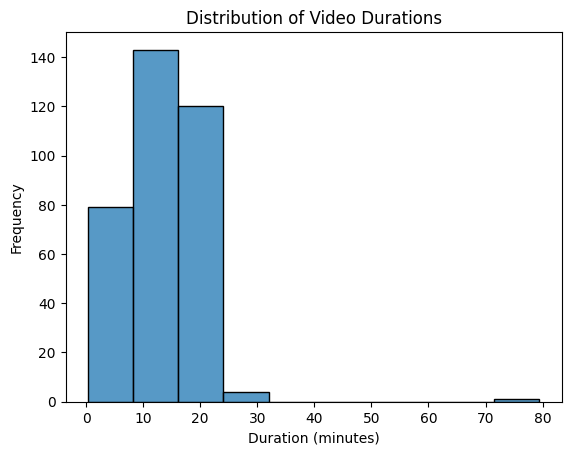

In [50]:
# Convert timedelta to seconds for plotting
video_cleaned['dur_minutes'] = video_cleaned['dur_readable'] / pd.Timedelta(minutes=1)

# Plot histogram of duration distribution
sns.histplot(video_cleaned['dur_minutes'], bins=10)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.title('Distribution of Video Durations')
plt.show()

### Video views distribution

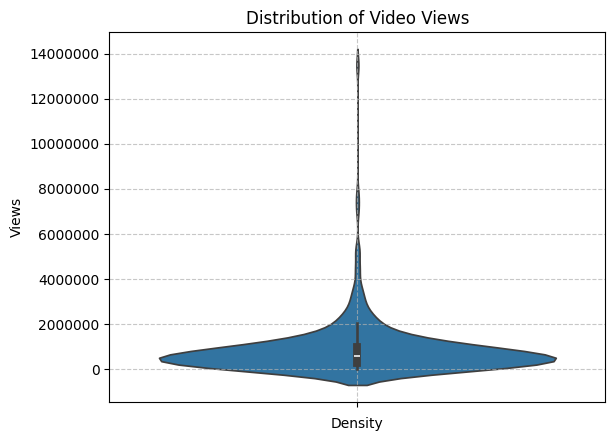

In [51]:
sns.violinplot(video_cleaned['views'])

palette = "viridis"

# Get the current axes
ax = plt.gca()


# Add title and axis labels
plt.title("Distribution of Video Views")
plt.xlabel("Density")
plt.ylabel("Views")

# Format y-axis tick labels without scientific notation
ax.ticklabel_format(style='plain', axis='y')

# Customize the appearance
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines

In [52]:
# Split rows with multiple countries into separate rows
video_cleaned['country'] = video_cleaned['country'].str.split(', ')
video_cleaned = video_cleaned.explode('country')

# Exclude rows with 'No specific country'
video_cleaned_filtered = video_cleaned[video_cleaned['country'] != 'No specific country']

# Count occurrences of each country
country_counts = video_cleaned_filtered['country'].value_counts()

# Select only the top 10 most tagged countries
top_10 = country_counts.head(10)

# Create horizontal bar plot using Plotly graph objects
fig = go.Figure(go.Bar(
    x=top_10.values,
    y=top_10.index,
    orientation='h',
    marker=dict(color='skyblue'),  # Bar color
))

# Update layout
fig.update_layout(
    title='Most Tagged Countries in Titles',
    xaxis_title='Tag Count',
    yaxis_title='Country',
    yaxis=dict(autorange="reversed"), # Reverse y-axis to have the country with the highest count at the top
    template='plotly_white',  # Plotly template
    height=600,  
)

# Show the plot
fig.show()

### Video publication by day of the week

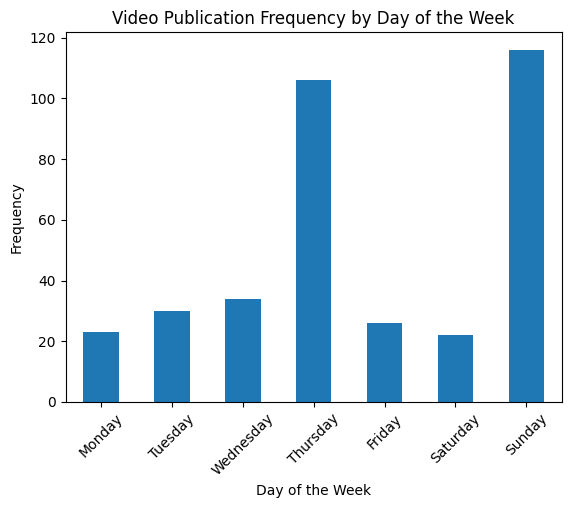

In [53]:
day_df = pd.DataFrame(video_cleaned['weekday'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)

# Plot the bar chart
ax = day_df.plot.bar(rot=45, legend=False)
ax.set_xlabel('Day of the Week')
ax.set_ylabel('Frequency')
ax.set_title('Video Publication Frequency by Day of the Week')
plt.show()

In [54]:
video_cleaned.columns


Index(['video_id', 'channel', 'title', 'description', 'tags', 'published_at',
       'views', 'likes', 'comments', 'duration', 'year', 'month_name',
       'day_num', 'weekday', 'hour', 'dur_readable', 'tag_count', 'tags_list',
       'processed_title', 'pos_tags', 'words_set', 'keywords', 'country',
       'dur_minutes'],
      dtype='object')

### Videos uploaded by month and year

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


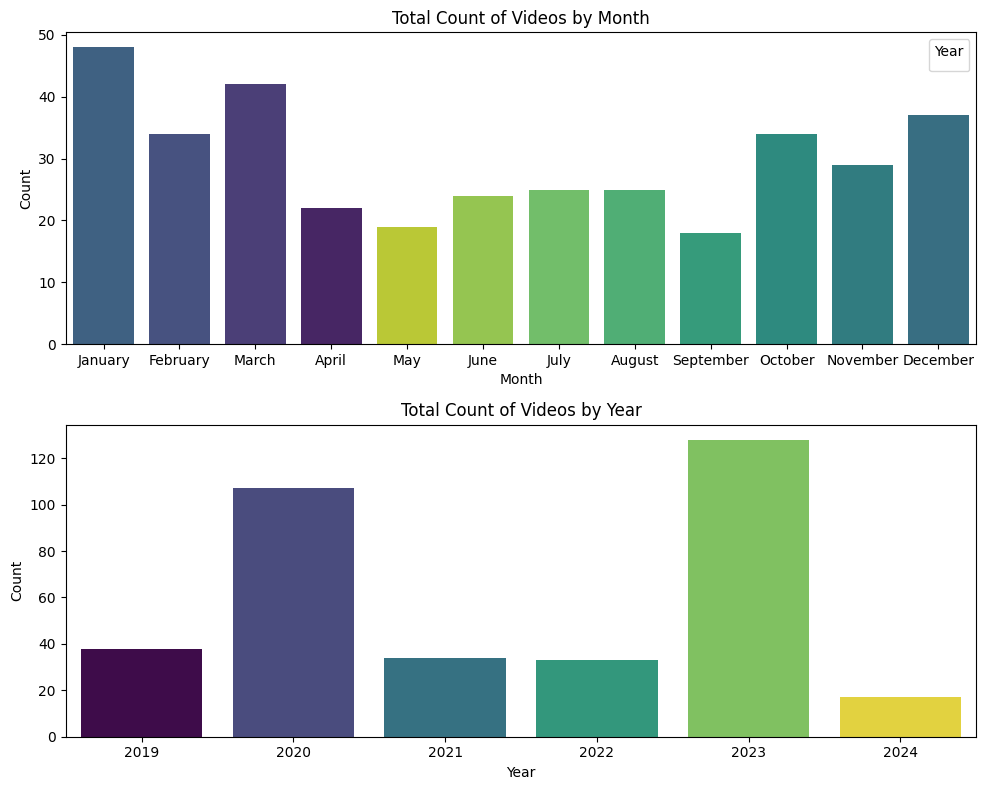

In [55]:
# Define custom order for months
custom_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plot total count of videos by month
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
sns.countplot(x='month_name', data=video_cleaned, order=custom_order, hue='month_name', palette='viridis', legend=False)
plt.title('Total Count of Videos by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(title='Year')

# Plot total count of videos by year
plt.subplot(2, 1, 2)
sns.countplot(x='year', data=video_cleaned, hue='year', palette='viridis', legend=False)
plt.title('Total Count of Videos by Year')
plt.xlabel('Year')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



### Relationship between views, comments and likes

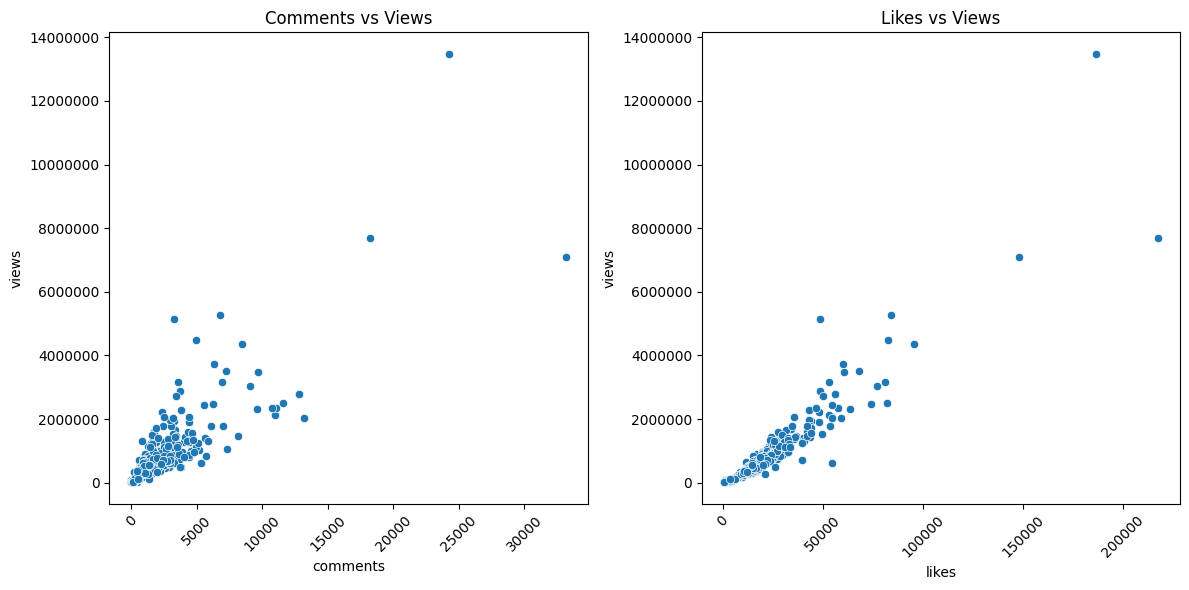

In [56]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figsize as needed

# Plot scatterplot for 'comments' vs 'views'
sns.scatterplot(data=video_cleaned, x='comments', y='views', ax=ax[0])
ax[0].set_title('Comments vs Views')
ax[0].ticklabel_format(style='plain', axis='y')  # Remove scientific notation
ax[0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Plot scatterplot for 'likes' vs 'views'
sns.scatterplot(data=video_cleaned, x='likes', y='views', ax=ax[1])
ax[1].set_title('Likes vs Views')
ax[1].ticklabel_format(style='plain', axis='y')  # Remove scientific notation
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()


### Word clouds

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sydney\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


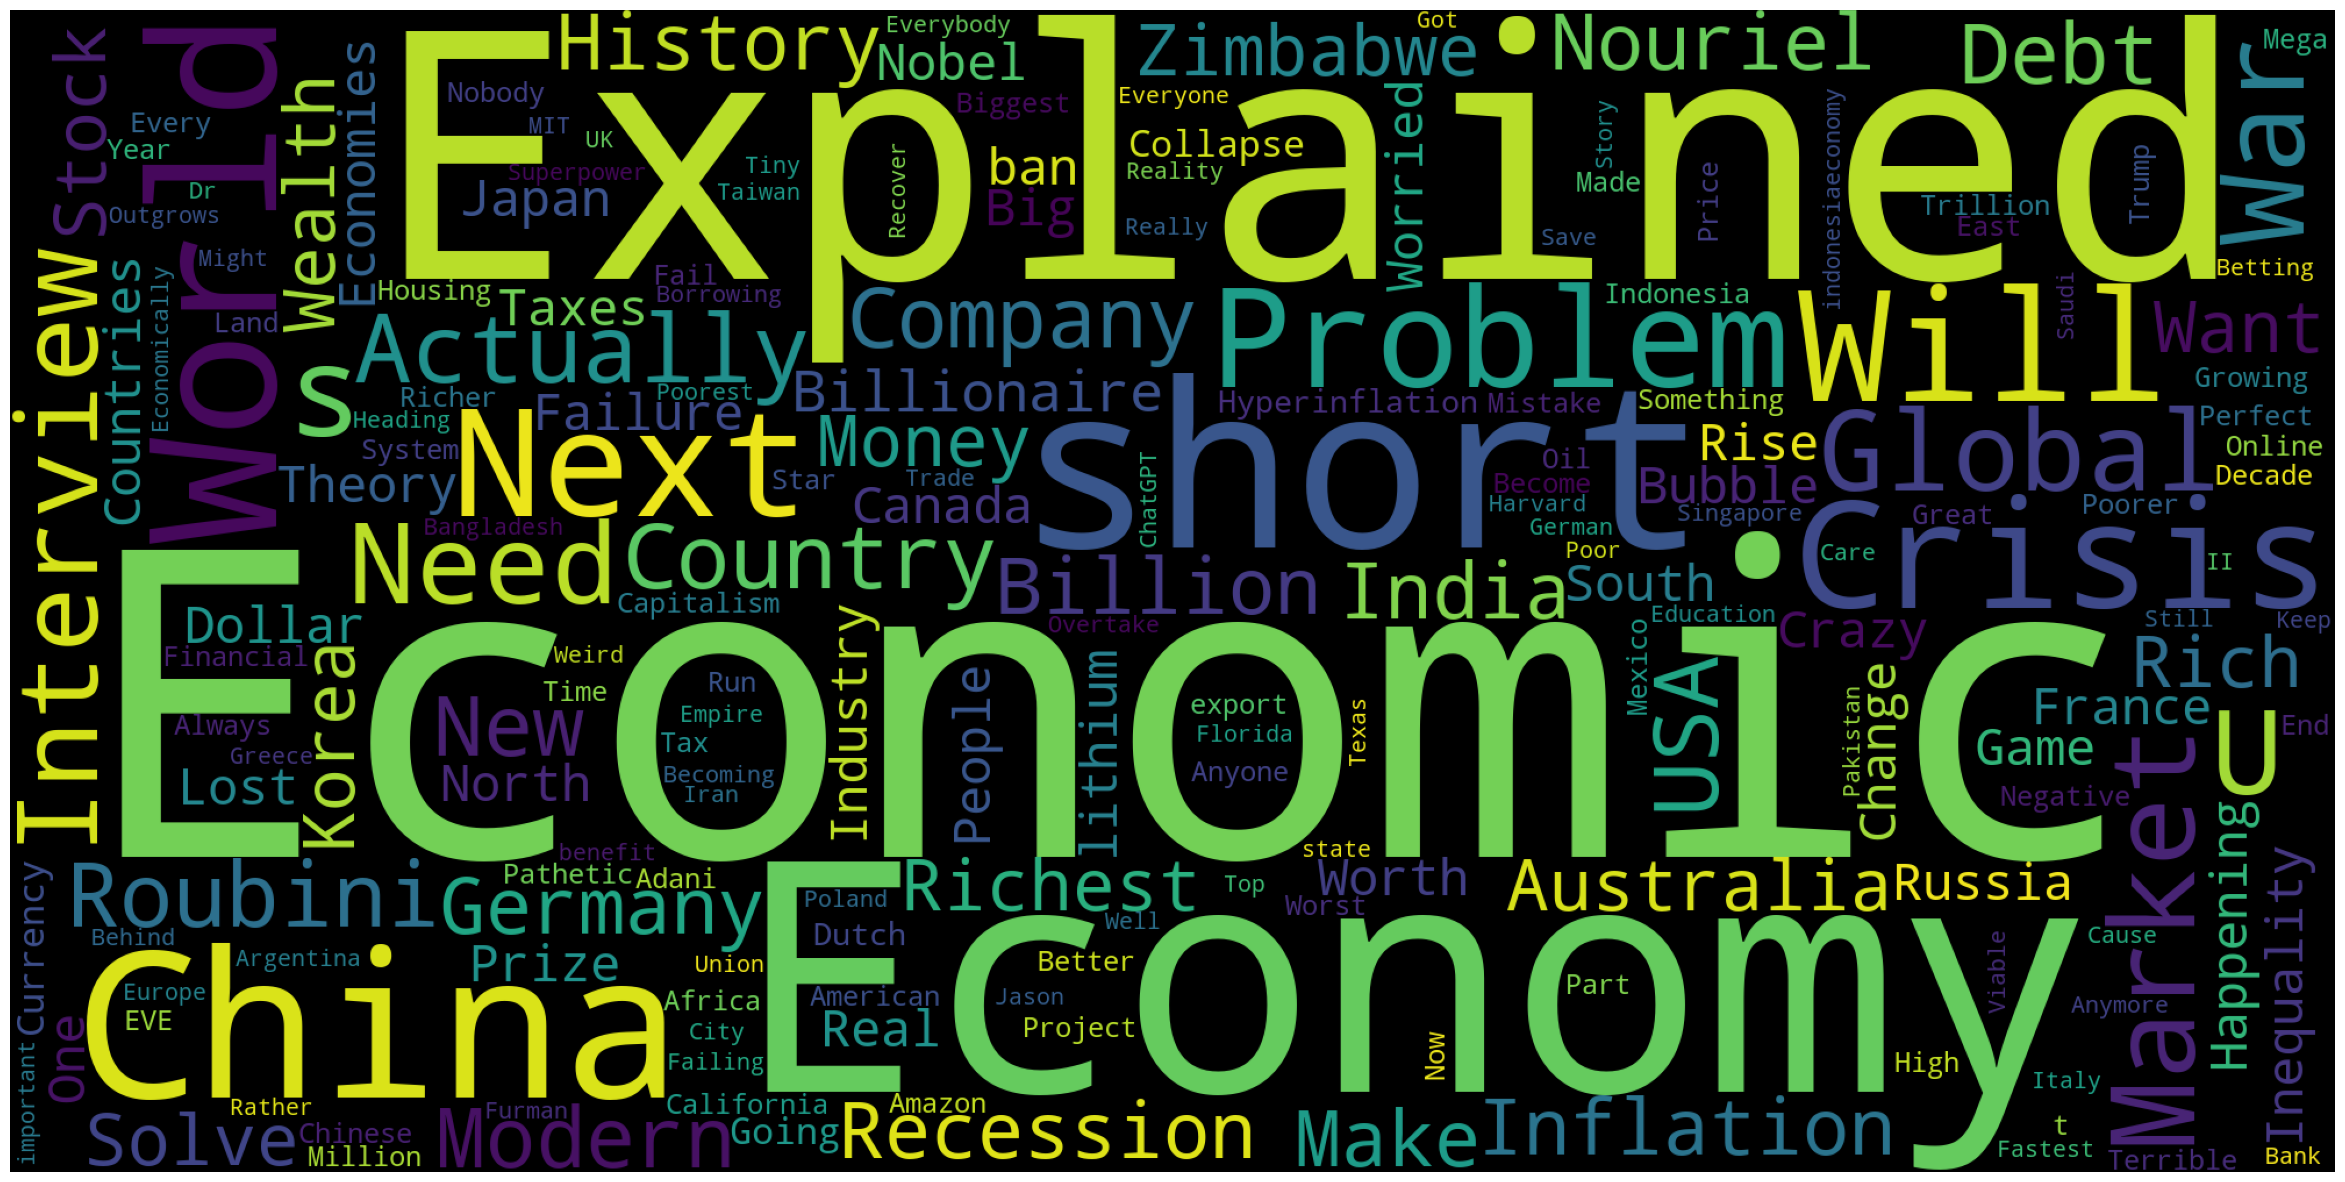

In [57]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download NLTK stopwords corpus
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
video_cleaned['title_no_stopw'] = video_cleaned['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_cleaned['title_no_stopw'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off');

wordcloud = WordCloud(width= 2000, height=1000, random_state=1, background_color='black', colormap='viridis', collocations=False).generate(all_words_str)

plot_cloud(wordcloud)

In [58]:
stop_words = set(stopwords.words('english'))
video_cleaned['title_no_stopw'] = video_cleaned['processed_title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_cleaned['title_no_stopw'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off');

wordcloud = WordCloud(width= 2000, height=1000, random_state=1, background_color='black', colormap='viridis', collocations=False).generate(all_words_str)

plot_cloud(wordcloud)

## Part 4. Regression model

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define independent and dependent variables
X = video_cleaned[['comments', 'likes']]  # Independent variables
y = video_cleaned['views']  # Dependent variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Get the intercept and the coefficients for the independent variables
intercept = model.intercept_
coefficients = model.coef_

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)

print("Mean absolute error:", round(mae,4))
print("Mean Squared Error:", round(mse, 4))
print("Root Mean Squared Error:", round(rmse,4))
print("R-squared score:", round(r_squared,4))

# Printing the intercept and the coefficients
print(f"Intercept: {intercept}")
for i, coef in enumerate(coefficients):
    print(f"Coefficient for {X.columns[i]}: {coef}")

# Printing the equation for the model
equation = f"Views = {intercept:,.2f} "

for i, coef in enumerate(coefficients):
    equation += f"+ {coef:.2f} * {X.columns[i]} "

print("Equation for the model:", equation)



Mean absolute error: 169849.6741
Mean Squared Error: 53585140264.9611
Root Mean Squared Error: 231484.6437
R-squared score: 0.9029
Intercept: -205008.24838989286
Coefficient for comments: 23.73614761552725
Coefficient for likes: 46.11123410131228
Equation for the model: Views = -205,008.25 + 23.74 * comments + 46.11 * likes 


c:\Users\Sydney\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



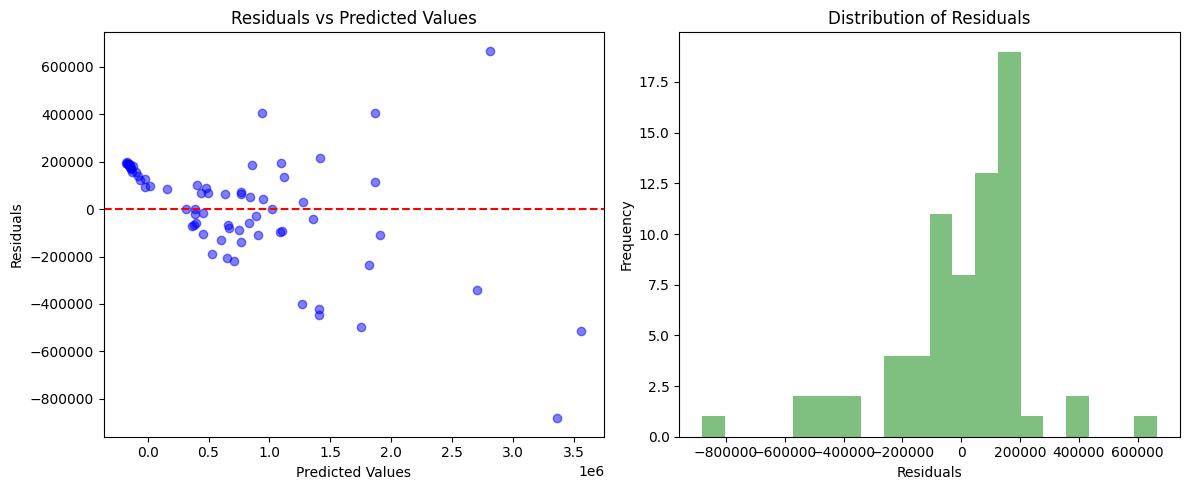

In [ ]:
# Checking homoscedasticity

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals against predicted values
plt.figure(figsize=(12, 5))

# Residuals vs Predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residuals distribution
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, color='green', alpha=0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



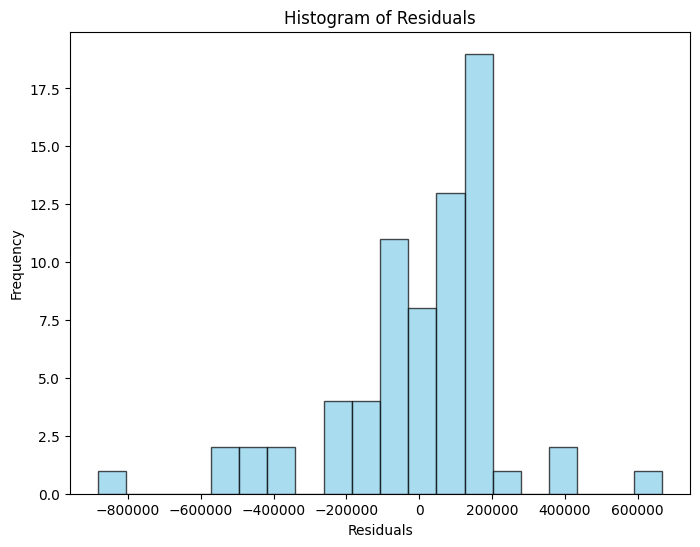

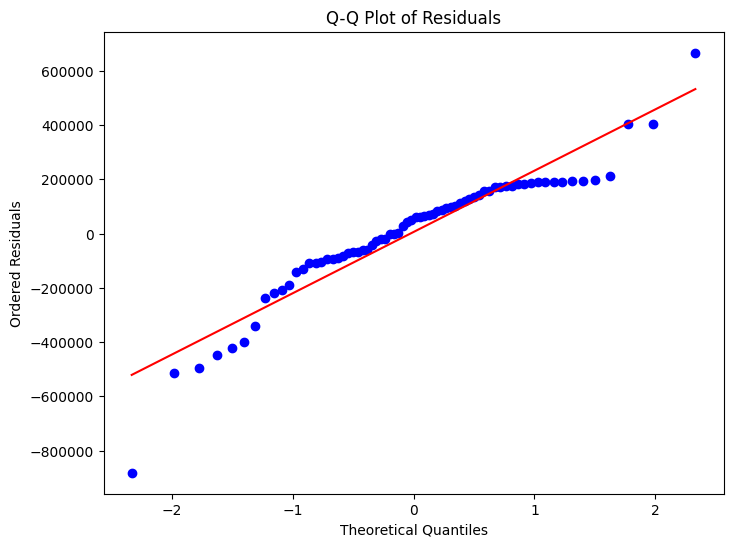

Shapiro-Wilk test p-value: 0.00018070958321914077


In [ ]:
# Checking residuals normality

import matplotlib.pyplot as plt
import scipy.stats as stats

# Calculate residuals
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Residuals')
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(residuals)
print("Shapiro-Wilk test p-value:", shapiro_test[1])


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data = X_train.copy()
vif_data['Intercept'] = 1  # Add an intercept column for calculating VIF
vif = pd.DataFrame()
vif["Feature"] = vif_data.columns
vif["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print("Variance Inflation Factors:")
print(vif)


Variance Inflation Factors:
     Feature       VIF
0   comments  4.106988
1      likes  4.106988
2  Intercept  1.901521
